In [32]:
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
df = pd.read_csv('data_small.txt', sep = "\t", names =  ['0', '1', '2', '3', '4', '5', '6'])

In [34]:
pd.DataFrame(df)

,0,1,2,3,4,5,6
0,0,40,50,0,0,1236,0
1,1,42,66,20,65,146,90
2,2,42,65,20,15,67,90
3,3,40,69,20,621,702,90
4,4,38,68,20,255,324,90
5,5,38,70,10,534,605,90
6,6,41,51,30,448,505,90


In [35]:
import numpy as np
from gurobipy import GRB
from gurobipy import *

In [36]:

# read data_large.text and data_small.text

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# read data_large.text and data_small.text
data_large = pd.read_csv('data_large.txt', sep='\t', names=['Location ID', 'X_Coordinate', 'Y_Coordinate', 'Demand', 'Ready Time', 'Due Date', 'Service Time'])
data_small = pd.read_csv('data_small.txt', sep='\t', names=['Location ID', 'X_Coordinate', 'Y_Coordinate', 'Demand', 'Ready Time', 'Due Date', 'Service Time'])

# show the entire data
#print(data_large)
#print(data_small)

# make matrix in pandas of data with 1 collom being 0, 1, 2, 3, 4, 5, 6 and the other being 0, 65, 15, 621, 255, 534, 448



# first collum is location_ID
LOC_ID = (data_small.iloc[:,0])
# convert the location_ID to a list
LOC_ID = LOC_ID.tolist()

# second collum is X_coordinate
X_COORD = (data_small.iloc[:,1])

# third collum is Y_coordinate
Y_COORD = (data_small.iloc[:,2])

# fourth collum is demand at the location
DEMAND = (data_small.iloc[:,3])

# fifth collum is ready time at the location
READYTIME = (data_small.iloc[:,4])


print(READYTIME)


# sixth collum is due time at the location
DUETIME = (data_small.iloc[:,5])

# seventh collum is service time at the location
SERVICETIME = (data_small.iloc[:,6])
# convert the service time to a list
SERVICETIME = SERVICETIME.tolist()

M = 1000000     # Large integer for 

c_matrix = np.zeros([len(LOC_ID), len(LOC_ID)])
for i in range(len(LOC_ID)):
    for j in range(len(LOC_ID)):
                if i == j:
                    c_matrix[i][j] = M
                else:
                    c_matrix[i][j] = np.sqrt((X_COORD[j] - X_COORD[i]) ** 2 + (Y_COORD[j] - Y_COORD[i]) ** 2)
# convert the matrix to a dataframe
c_matrix = pd.DataFrame(c_matrix)

dist = {(LOC_ID[i], LOC_ID[j]): c_matrix[i][j] for i,j in combinations(LOC_ID, 2)}

print(dist[0,1])


0      0
1     65
2     15
3    621
4    255
5    534
6    448
Name: Ready Time, dtype: int64
16.1245154965971


In [44]:
time = 0
# ---- Model ----
import gurobipy as gp
from gurobipy import GRB

m = gp.Model('TSP')

# ---- Variables ----

# Decision Variable x(i,j) (Distance travelled between node i and node j)

x = m.addVars (dist.keys(), obj = dist,  vtype = GRB.BINARY, name = 'x')

# Decision Variable t(i) (Time at node i)
t = m.addVars (dist.keys(),  vtype = GRB.CONTINUOUS, name = 't')
   
# ---- Constraints ----

# contraint 1: symetry contraint

for i,j in x.keys():
    x[j, i] = x[i, j]

# conraint 2: two edges per node

cons = m.addConstrs(x.sum(i, '*') == 2 for i in LOC_ID)

# constraint 3: time window constraint

for i in LOC_ID:
    
        for j in LOC_ID:
            m.addConstr(t[i,j] >= READYTIME[i] + SERVICETIME[i] + dist[i,j])
            m.addConstr(t[i,j] <= DUETIME[i] + SERVICETIME[i] + dist[i,j])


# Callback - use lazy constraints to eliminate sub-tours

def subtourelim(model, where):
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        vals = model.cbGetSolution(m._x)
        selected = gp.tuplelist((i, j) for i, j in model._x.keys()
                             if vals[i, j] > 0.5)
        # find the shortest cycle in the selected edge list
        tour = subtour(selected)
        if len(tour) < len(LOC_ID):
            # add subtour elimination constr. for every pair of cities in subtour
            m.cbLazy(gp.quicksum(model._x[i, j] for i, j in combinations(tour, 2))
                         <= len(tour)-1)

# Given a tuplelist of edges, find the shortest subtour

def subtour(edges):
    unvisited = LOC_ID[:]
    cycle = LOC_ID[:] # Dummy - guaranteed to be replaced
    while unvisited:  # true if list is non-empty
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*')
                         if j in unvisited]
        if len(thiscycle) <= len(cycle):
            cycle = thiscycle # New shortest subtour
    return cycle

# ---- Solve ----

m._x = x
m.Params.lazyConstraints = 1
m.optimize (subtourelim)


KeyError: (1, 0)

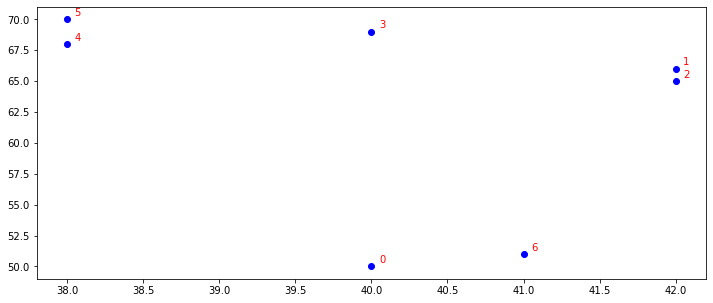

In [ ]:
plt.figure(figsize = (12, 5))
for i in range(len(LOC_ID)):
    plt.scatter(X_COORD[i], Y_COORD[i], color = 'blue') 
    plt.annotate(str(LOC_ID[i]), xy = (X_COORD[i], Y_COORD[i]), xytext = (X_COORD[i] + 0.05, Y_COORD[i] + 0.3), color = 'red')

In [ ]:
vals = m.getAttr('x', x)
selected = gp.tuplelist((i, j) for i, j in x.keys() if vals[i, j] > 0.5)

tour = subtour(selected)
print(tour)



[0, 4, 5, 3, 1, 2, 6]
